In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("emulation_data/ffmpeg_summary_v2.csv")
df = df.sort_values(by=["cpu-allocated", "resolution", "num_task"])

# Change time-elapsed to 
# df["time-elapsed"] = (120 * 30 / df["avg-fps"]).apply(lambda x: float(f"{x:.2f}"))

In [9]:
df = pd.read_csv("emulation_data/ffmpeg_summary.csv")
df = df.sort_values(by=["cpu-allocated", "resolution", "num_task"])
df.loc[df["cpu-allocated"] == 15,"memory_allocated"] = 16384


In [3]:
df["tc_per_sec"] = (df["task-clock(ms)"] * df["num_task"] / df["time-elapsed"]).apply(lambda x: float(f"{x:.2f}"))
df["tc_per_frame"] = (df["task-clock(ms)"] / (df["time-elapsed"] * df["avg-fps"])).apply(lambda x: float(f"{x:.2f}"))
df["mem_per_task"] = ((df["memory_allocated"] * df["avg-system-Memory(%)"] * 0.01) / df["num_task"]).apply(lambda x: float(f"{x:.2f}"))

In [4]:
df.to_csv("emulation_data/ffmpeg_summary_sorted.csv")

<Axes: ylabel='Frequency'>

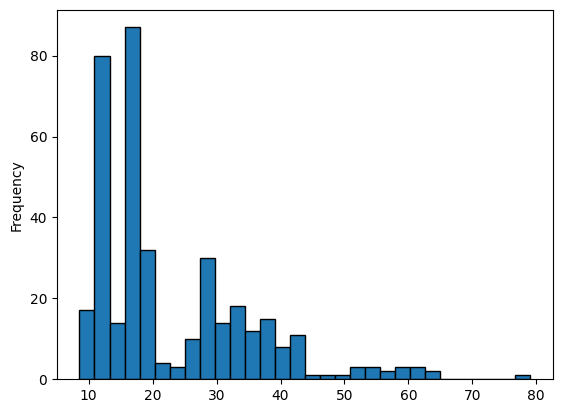

In [5]:
# Plot y-axis = tc_per_frame || x-axis = num_task
df.loc[df["cpu-allocated"] == 10, "tc_per_frame"].plot.hist(bins=30, edgecolor='black')

### Resolution Comparison

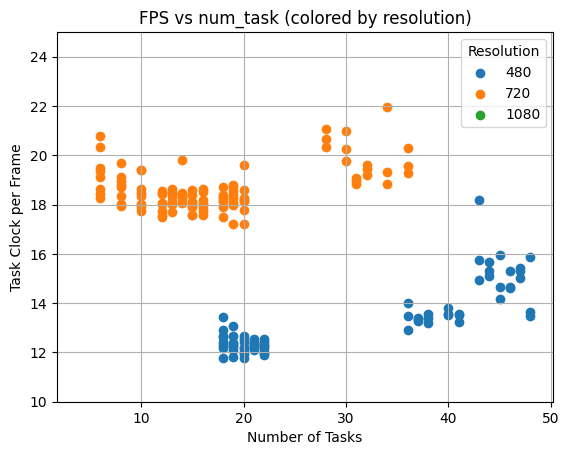

In [6]:
import matplotlib.pyplot as plt

# Filter your data
subset = df.loc[df["cpu-allocated"] == 10]
subset = df.loc[df["memory_allocated"] == 4101230592]

# Plot manually with different colors for each resolution
fig, ax = plt.subplots()

for label, group in subset.groupby("resolution"):
    # ax.scatter(group["num_task"], group["mem_per_task"], label=label)
    ax.scatter(group["num_task"], group["tc_per_frame"], label=label)

ax.set_title("FPS vs num_task (colored by resolution)")
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Task Clock per Frame")
ax.set_ylim(10,25)
ax.grid(True)
ax.legend(title="Resolution")
plt.show()

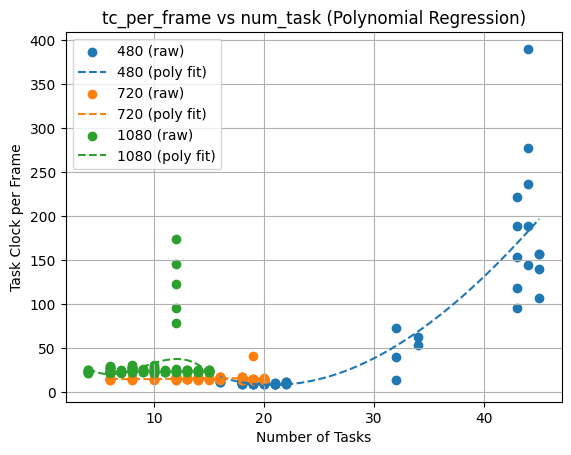

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Choose polynomial degree (start with 2 or 3)
poly_degree = 3

subset = df[df["cpu-allocated"] == 5]

# subset = df[df["memory_allocated"] == 5]
fig, ax = plt.subplots()

for label, group in subset.groupby("resolution"):
    x = group["num_task"].values.reshape(-1, 1)
    y = group["tc_per_frame"].values

    # Polynomial features
    poly = PolynomialFeatures(degree=poly_degree)
    X_poly = poly.fit_transform(x)

    # Fit polynomial regression
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict over a smooth range
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_fit = model.predict(poly.transform(x_fit))

    # Plot raw and fitted data
    ax.scatter(x, y, label=f"{label} (raw)")
    ax.plot(x_fit, y_fit, linestyle='--', label=f"{label} (poly fit)")

ax.set_title("tc_per_frame vs num_task (Polynomial Regression)")
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Task Clock per Frame")
ax.grid(True)
ax.legend()
plt.show()

### CPU Comparison

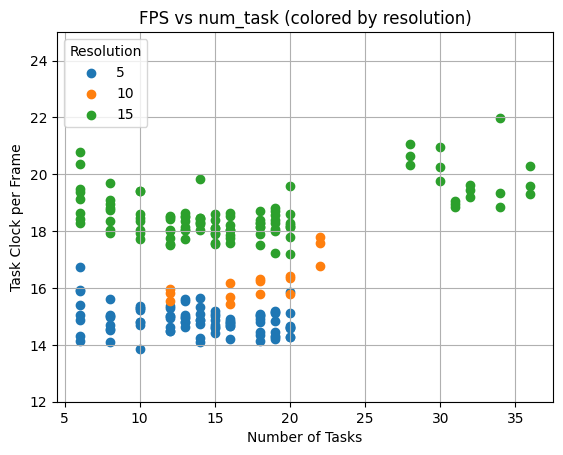

In [33]:
# Filter your data
subset = df.loc[df["resolution"] == 720]

# Plot manually with different colors for each resolution
fig, ax = plt.subplots()

for label, group in subset.groupby("cpu-allocated"):
    # ax.scatter(group["num_task"], group["mem_per_task"], label=label)
    ax.scatter(group["num_task"], group["tc_per_frame"], label=label)

ax.set_title("FPS vs num_task (colored by resolution)")
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Task Clock per Frame")
ax.set_ylim(12,25)
ax.grid(True)
ax.legend(title="Resolution")
plt.show()

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Let's assume df is your DataFrame
features = ["num_task", "cpu-allocated", "memory_allocated", "resolution"]

# Encode resolution if it's categorical (e.g., "720p", "1080p")
# if df["resolution"].dtype == object:
    # df["resolution"] = df["resolution"].astype("category").cat.codes
    
X = df[features]
y = df["tc_per_frame"]
# y = df["mem_per_task"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

Test MSE: 16.1701


/home/vincent/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/vincent/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/vincent/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


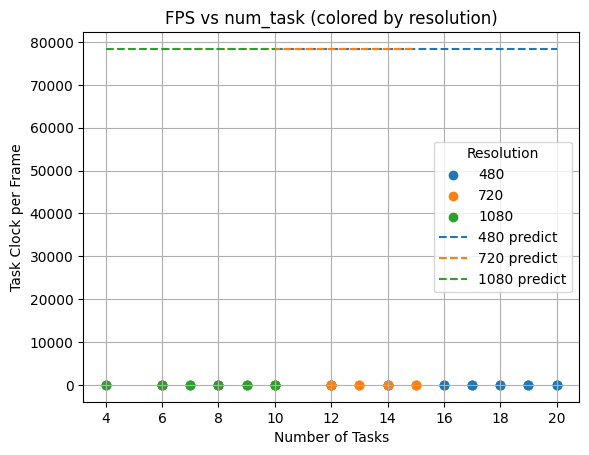

In [ ]:
import matplotlib.pyplot as plt

# Filter your data
subset = df.loc[df["cpu-allocated"] == 10]

# Plot manually with different colors for each resolution
fig, ax = plt.subplots()

for label, group in subset.groupby("resolution"):
    ax.scatter(group["num_task"], group["tc_per_frame"], label=label)
    # ax.scatter(group["num_task"], group["mem_per_task"], label=label)
    
for label, group in subset.groupby("resolution"):
    pred = model.predict(group[features])
    ax.plot(group["num_task"], pred, linestyle="--",  label=str(label) + " predict")

ax.set_title("FPS vs num_task (colored by resolution)")
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Task Clock per Frame")
ax.grid(True)
ax.legend(title="Resolution")
plt.show()